In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
sns.set()
warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import average_precision_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/data Paysim/pysim.csv')
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
data.shape


(6362620, 11)

In [ ]:
data.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
# Correcting inconsistency in column name
data = data.rename(columns={'oldbalanceOrg':'oldbalanceOrig'})

In [ ]:
# Transform categorical feature(s) to numeric
le = LabelEncoder()
data.type = le.fit_transform(data.type)

In [ ]:
data.drop(columns=['nameDest', 'nameOrig'], axis=1, inplace=True)
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   oldbalanceOrig  float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
dtypes: float64(5), int64(4)
memory usage: 436.9 MB


(6362620, 9)

In [ ]:
X = data.drop('isFraud', axis=1)
Y = data['isFraud']
x = StandardScaler().fit_transform(X)


In [ ]:
# Fit PCA on X_features 
from sklearn.decomposition import PCA 
pca = PCA(n_components = 8)

transformed_data = pca.fit_transform(x)
print(transformed_data.shape)
print(pca.explained_variance_ratio_*100)
print(pca.explained_variance_)

(6362620, 8)
[2.90600080e+01 2.61973911e+01 1.25439355e+01 1.24482966e+01
 1.10888124e+01 8.56022975e+00 8.78008016e-02 1.35258898e-02]
[2.32480100e+00 2.09579162e+00 1.00351500e+00 9.95863886e-01
 8.87105131e-01 6.84818488e-01 7.02406523e-03 1.08207135e-03]


0.9998647411021092


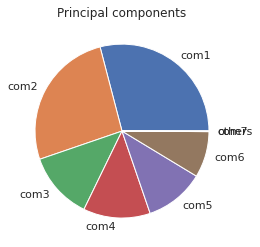

In [ ]:
# Plot the principal components in pie chart, and only keep the components that 
# contains 95% information of original dataset.
threshold = 0.95
for_test = 0
order = 0 
for index, ratio in enumerate(pca.explained_variance_ratio_):
    if threshold > for_test:
        for_test += ratio 
    else:
        order = index + 1 
        break 

print(pca.explained_variance_ratio_[:order].sum())
com_col = ['com'+ str(i+1) for i in range(order)]
com_col.append('others')
com_value = [i for i in pca.explained_variance_ratio_[:order]]
com_value.append(1-pca.explained_variance_ratio_[:order].sum())
plt.figure(figsize=[4,4])
plt.pie(x = com_value, labels = com_col)
plt.title('Principal components')
plt.show()

In [ ]:
#Train Test split
from sklearn.model_selection import train_test_split

# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size=0.3, random_state=1)

# describes info about train and test set
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4453834, 8)
Number transactions y_train dataset:  (4453834,)
Number transactions X_test dataset:  (1908786, 8)
Number transactions y_test dataset:  (1908786,)


In [ ]:
#Class Balancing
#Through SMOTE
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 5745
Before OverSampling, counts of label '0': 4448089 

After OverSampling, the shape of train_X: (8896178, 8)
After OverSampling, the shape of train_y: (8896178,) 

After OverSampling, counts of label '1': 4448089
After OverSampling, counts of label '0': 4448089


In [ ]:
#Neural Network

In [ ]:
m = Sequential()

In [ ]:
# Adding the input layer and first Hidden Layer
m.add(Dense(activation = "relu", input_dim =8 , units = 3, kernel_initializer='uniform' ))

# Adding the Second hidden layer
m.add(Dense(activation = "relu", units =20, kernel_initializer='uniform'))

# Adding the third hidden layer
m.add(Dense(activation = "relu", units = 10, kernel_initializer='uniform'))

# Addinng the output Layer
m.add(Dense(activation = 'sigmoid', units =1, kernel_initializer='uniform',))

m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 27        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 328
Trainable params: 328
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compiling the ANN
m.compile(optimizer='adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

In [ ]:
# Fitting the ANN to the training set
h=m.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size = 100, epochs =10)

Epoch 1/10
88962/88962 [==============================] - 129s 1ms/step - loss: 0.0360 - accuracy: 0.9896 - val_loss: 0.0403 - val_accuracy: 0.9857
Epoch 2/10
88962/88962 [==============================] - 127s 1ms/step - loss: 0.0346 - accuracy: 0.9900 - val_loss: 0.0438 - val_accuracy: 0.9853
Epoch 3/10
88962/88962 [==============================] - 127s 1ms/step - loss: 0.0341 - accuracy: 0.9902 - val_loss: 0.0346 - val_accuracy: 0.9881
Epoch 4/10
88962/88962 [==============================] - 133s 1ms/step - loss: 0.0342 - accuracy: 0.9902 - val_loss: 0.0227 - val_accuracy: 0.9936
Epoch 5/10
88962/88962 [==============================] - 132s 1ms/step - loss: 0.0338 - accuracy: 0.9903 - val_loss: 0.0557 - val_accuracy: 0.9815
Epoch 6/10
88962/88962 [==============================] - 127s 1ms/step - loss: 0.0332 - accuracy: 0.9906 - val_loss: 0.0385 - val_accuracy: 0.9878
Epoch 7/10
88962/88962 [==============================] - 133s 1ms/step - loss: 0.0329 - accuracy: 0.9907 - val_

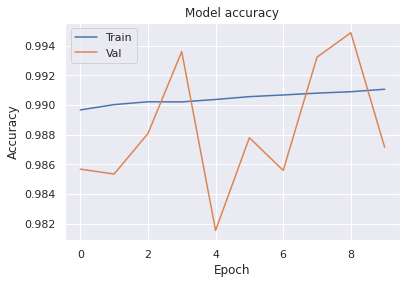

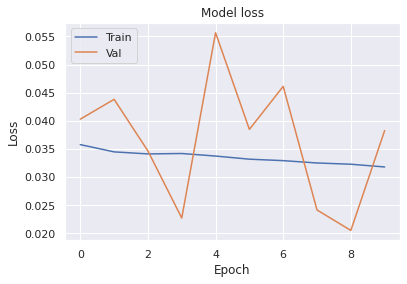

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot( h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

  # Plot training & validation loss values
plt.plot( h.history['loss'])
plt.plot( h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:

# Making the Prediction and Evaluating the model
# Predicting the Test set result
y_pred = m.predict(X_test)
y_pred = (y_pred>0.5)

In [ ]:


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_roc_curve
acc9 = accuracy_score(y_test, y_pred )
prec9 = precision_score(y_test, y_pred )
rec9 = recall_score(y_test,y_pred )
f19 = f1_score(y_test, y_pred  )
print('accuracy:%0.4f'%acc9,'\tprecision:%0.4f'%prec9,'\trecall:%0.4f'%rec9,'\tF1-score:%0.4f'%f19)

accuracy:0.9872 	precision:0.0912 	recall:0.9964 	F1-score:0.1670


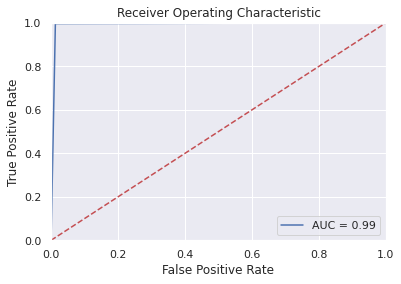

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


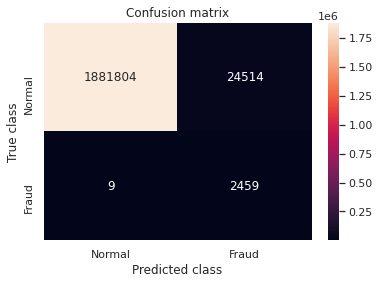

In [ ]:
#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred )
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:

X_train.shape, X_test.shape

((8896178, 8, 1), (1908786, 8, 1))

In [ ]:
#Build CNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.5.0


In [ ]:
epochs = 10
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape = X_train[8].shape))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 32)             128       
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 32)             128       
_________________________________________________________________
dropout (Dropout)            (None, 6, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 64)             6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 64)             256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [ ]:

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
278006/278006 [==============================] - 915s 3ms/step - loss: 0.0575 - accuracy: 0.9798 - val_loss: 0.0385 - val_accuracy: 0.9852
Epoch 2/10
278006/278006 [==============================] - 936s 3ms/step - loss: 0.0376 - accuracy: 0.9882 - val_loss: 0.0305 - val_accuracy: 0.9885
Epoch 3/10
278006/278006 [==============================] - 879s 3ms/step - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.0351 - val_accuracy: 0.9864
Epoch 4/10
278006/278006 [==============================] - 866s 3ms/step - loss: 0.0349 - accuracy: 0.9892 - val_loss: 0.0260 - val_accuracy: 0.9903
Epoch 5/10
278006/278006 [==============================] - 871s 3ms/step - loss: 0.0343 - accuracy: 0.9894 - val_loss: 0.0345 - val_accuracy: 0.9879
Epoch 6/10
278006/278006 [==============================] - 824s 3ms/step - loss: 0.0338 - accuracy: 0.9896 - val_loss: 0.0296 - val_accuracy: 0.9893
Epoch 7/10
 39471/278006 [===>..........................] - ETA: 11:12 - loss: 0.0335 - accuracy: 0.

In [ ]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [ ]:
plot_learningCurve(history, epochs)

In [ ]:

# Making the Prediction and Evaluating the model
# Predicting the Test set result
cnn = model.predict(X_test)
cnn = (cnn>0.5)

In [ ]:


from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_roc_curve
acc10 = accuracy_score(y_test, cnn )
prec10 = precision_score(y_test, cnn )
rec10 = recall_score(y_test,cnn)
f110 = f1_score(y_test, cnn  )
print('accuracy:%0.4f'%acc10,'\tprecision:%0.4f'%prec10,'\trecall:%0.4f'%rec10,'\tF1-score:%0.4f'%f110)

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_test, cnn)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, cnn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
